In [1]:
import os 
import cv2
import numpy as np 
import matplotlib.pyplot as plt
import os

# Analyse du dataset

Le dataset est composé d'images de radiographies thoraciques. Le dataset est déjà divisé en train, val et test. Les images sont classées en NORMAL et PNEUMONIA et sont en niveaux de gris.

Le problème est donc un problème de classification binaire. L'objectif est de prédire si une personne est atteinte de pneumonie ou non.

Nous commençons par définir des fonctions utilitaires pour parcourir et afficher les images. Ça nous sera utile pour analyser les données et comprendre les caractéristiques des images.

In [2]:
common_path = "./chest_Xray"
images_files = os.listdir(common_path)
subfolders = ["train","val","test"]
categories = ["NORMAL","PNEUMONIA"]

# Permet de parcourir les images, et pour chaque image, on applique une fonction de callback
# On peut optionnellement appeler une fonction de callback pour chaque dossier
def browse_imgs(img_callback, path_folder_callback = None, limit_size = None):
    for subfolder in subfolders:
        for category in categories:
            # pour avoir tous les chemins des 6 dossiers
            folder_path = os.path.join(common_path, subfolder, category)
            # liste de toutes les images
            images_files = os.listdir(folder_path)
            if path_folder_callback is not None:
                path_folder_callback(folder_path, images_files)
            array_limit = limit_size if limit_size is not None else len(images_files)
            #récupération de toutes les (ou des 'limit_size' premières) images du dossier.
            for file_name in images_files[:array_limit]:
                image_path = os.path.join(folder_path,file_name)
                img = cv2.imread(image_path,cv2.IMREAD_GRAYSCALE)
                img_callback(img)
                
                
def display_imgs(imgs, titles = None, plot_size = (1,1), figsize = (10,8)):
    fig = plt.figure(figsize=figsize)
    index = 0
    for image, title in zip(imgs, titles):
        index += 1
        ax = fig.add_subplot(plot_size[0], plot_size[1], index) 
        ax.imshow(image, cmap="gray")
        ax.axis("off")
        if titles is not None:
            ax.set_title(title)

    plt.tight_layout()
    plt.show()

In [3]:
folders_infos = {}
current_folder = None
def get_folders_infos_callback(folder_path, images_files):
    global folders_infos, current_folder
    folders_infos[folder_path] = []
    current_folder = folder_path
    
def add_imgs_size_to_folders_infos_callback(img):
    folders_infos[current_folder].append(img.shape)

browse_imgs(add_imgs_size_to_folders_infos_callback, get_folders_infos_callback, limit_size=5)

for folder_path, imgs_sizes in folders_infos.items():
    print("tailles des premières images du dossier {} : {}".format(folder_path, imgs_sizes) )

tailles des premières images du dossier ./chest_Xray/train/NORMAL : [(1279, 1670), (1129, 1574), (1391, 1646), (1670, 1820), (1102, 1338)]
tailles des premières images du dossier ./chest_Xray/train/PNEUMONIA : [(560, 936), (1447, 1841), (928, 1352), (632, 1016), (688, 952)]
tailles des premières images du dossier ./chest_Xray/val/NORMAL : [(1416, 1736), (1225, 1632), (1040, 1272), (928, 1288), (1302, 1564)]
tailles des premières images du dossier ./chest_Xray/val/PNEUMONIA : [(592, 968), (712, 1072), (864, 1256), (664, 1152), (944, 1416)]
tailles des premières images du dossier ./chest_Xray/test/NORMAL : [(1357, 1890), (1504, 1741), (1326, 1862), (912, 1392), (1953, 2170)]
tailles des premières images du dossier ./chest_Xray/test/PNEUMONIA : [(640, 832), (560, 952), (936, 1216), (1144, 1592), (648, 1032)]


On constate que les radios sont de tailles différentes. L'uniformisation des données est une étape importante du prétraitement des données. Il faudra donc les redimensionner pour les passer en entrée d'un modèle de machine learning.

Analysons plus en détail l'hétérogénéité du dataset.

In [4]:
smallest_img = None
largest_img = None

def search_size_callback(img):
    global smallest_img, largest_img
    largest_img_size = largest_img.shape if largest_img is not None else None
    smallest_img_size = smallest_img.shape if smallest_img is not None else None
    img_size = img.shape
    if largest_img_size is None or img_size > largest_img_size:
        largest_img = img
    if smallest_img_size is None or img_size < smallest_img_size:
        smallest_img = img

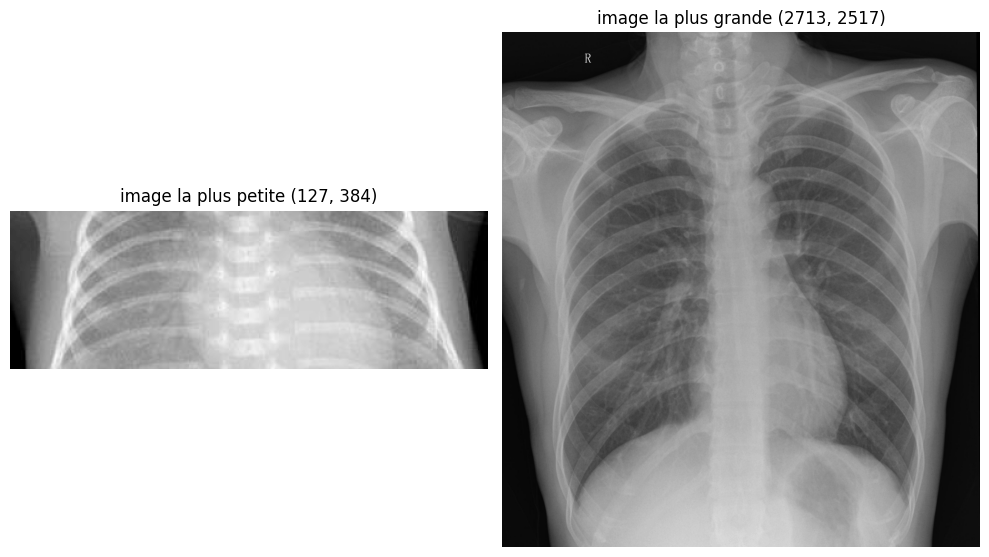

In [5]:
browse_imgs(search_size_callback)               
                    
display_imgs([smallest_img, largest_img], ["image la plus petite {}".format(smallest_img.shape), "image la plus grande {}".format(largest_img.shape)], (1,2))

Cet exemple illustre la grande hétérogénéité des tailles des images. On remarque notamment que certaines images sont inexploitables, à l'image de la plus petite qui rogne une partie de la radio.

Nous allons essayer de sélectionner les images en fonction de leurs ratios. L'objectif premier est de filtrer les images plus larges que longues, qui ne correspondent pas à un format radio.

In [6]:
def sort_image(img, min_ratio = 1, max_ratio = 1.5):
    height, width = img.shape
    ratio = width / height
    if min_ratio <= ratio <= max_ratio:
        return True
    else:
        return False

In [7]:
nb_imgs_before_sort = 0
# On stock les images de façon unique dans un tableau pour économiser la RAM
sorted_images = []
# On stock les index des images dans sorted_images pour chaque ratio
sorted_imgs_indexes = {1.1:[], 1.2:[], 1.3:[], 1.5:[], 1.6:[], 2:[]}

def sort_img_callback(img):
    global nb_imgs_before_sort, sorted_imgs_indexes, sorted_images
    nb_imgs_before_sort += 1
    for ratio_max, img_array in sorted_imgs_indexes.items():
        if sort_image(img, max_ratio=ratio_max):
            try:
                img_index = sorted_images.index(img)
                img_array.append(img_index)
            except ValueError:
                sorted_images.append(img)
                img_array.append(len(sorted_images)-1)
            
browse_imgs(sort_img_callback)

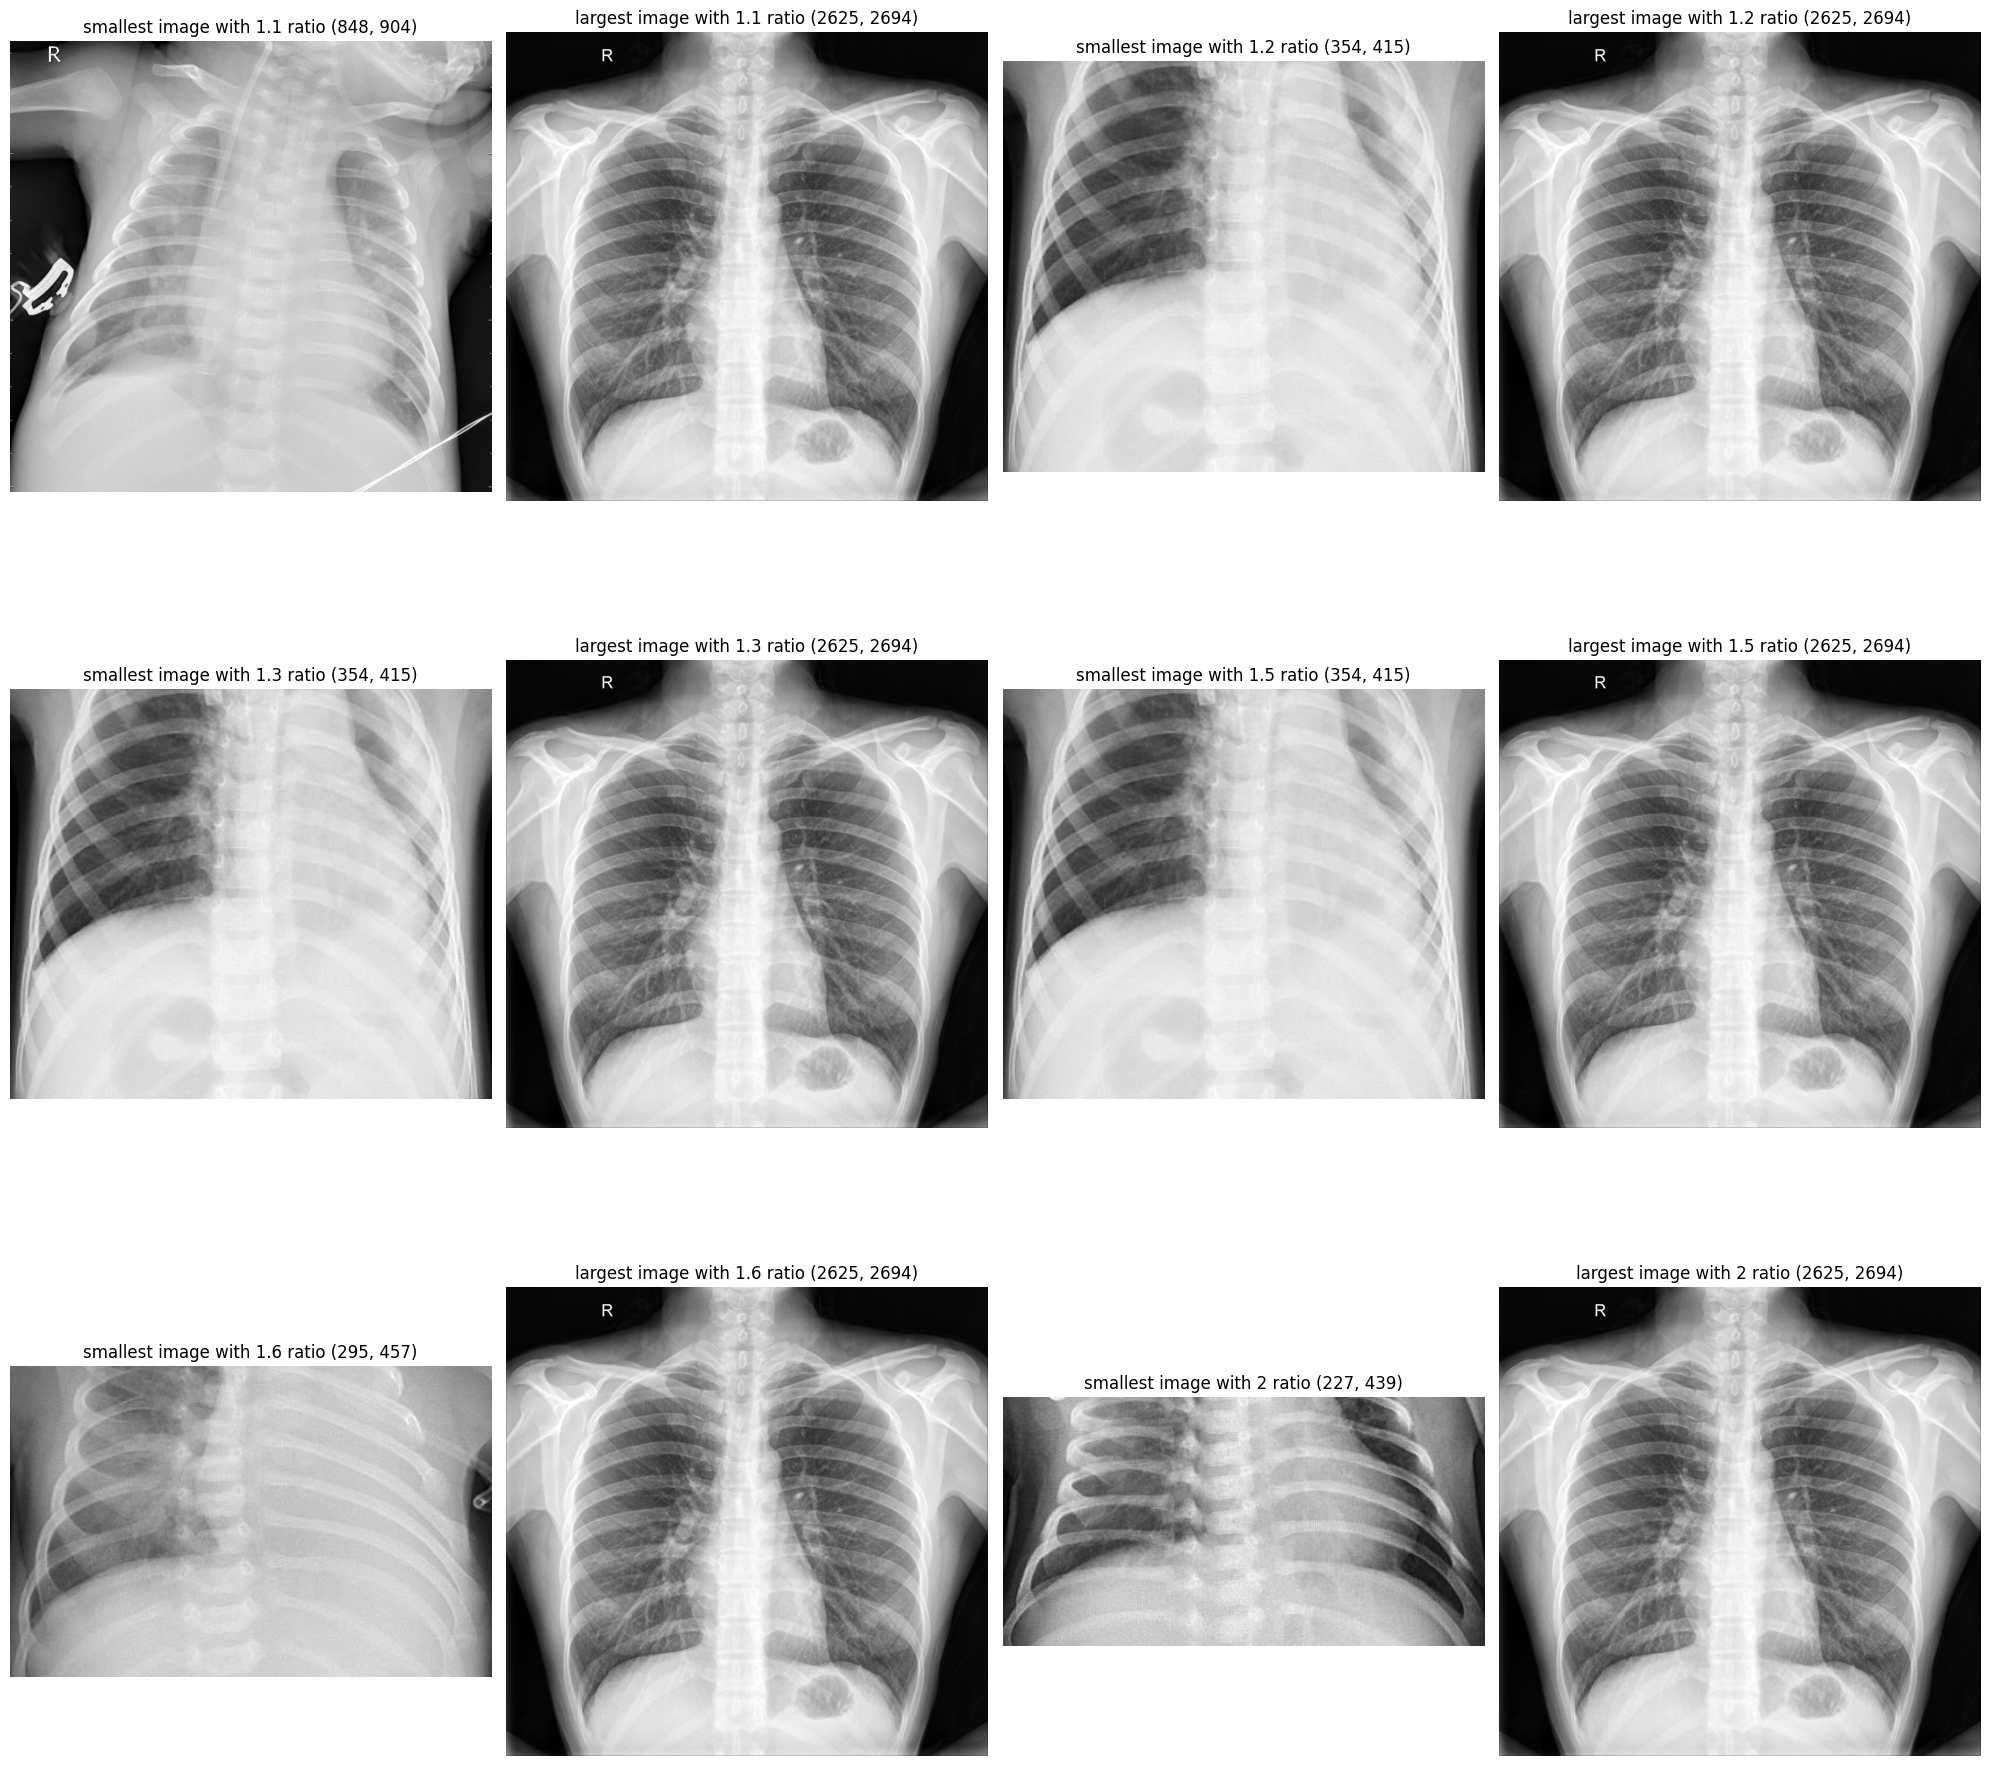

In [8]:
smallest_img = None
largest_img = None

imgs_to_display = []
titles = []
for ratio_max, indexes in sorted_imgs_indexes.items():
    for index in indexes:
        search_size_callback(sorted_images[index])
    imgs_to_display.append(smallest_img)
    titles.append("smallest image with {} ratio {}".format(ratio_max, smallest_img.shape))
    imgs_to_display.append(largest_img)
    titles.append("largest image with {} ratio {}".format(ratio_max, largest_img.shape))

display_imgs(imgs_to_display, titles, (int(len(sorted_imgs_indexes) / 2), 4), figsize=(20, 20))

In [9]:
print("Nombre d'images avant le prétraitement :", nb_imgs_before_sort)
for ratio_t, indexes_array in sorted_imgs_indexes.items():
    print("Nombre d'images après le prétraitement pour un ratio {} : {}".format(ratio_t, len(indexes_array)))

Nombre d'images avant le prétraitement : 5856
Nombre d'images après le prétraitement pour un ratio 1.1 : 238
Nombre d'images après le prétraitement pour un ratio 1.2 : 849
Nombre d'images après le prétraitement pour un ratio 1.3 : 1757
Nombre d'images après le prétraitement pour un ratio 1.5 : 3672
Nombre d'images après le prétraitement pour un ratio 1.6 : 4431
Nombre d'images après le prétraitement pour un ratio 2 : 5668


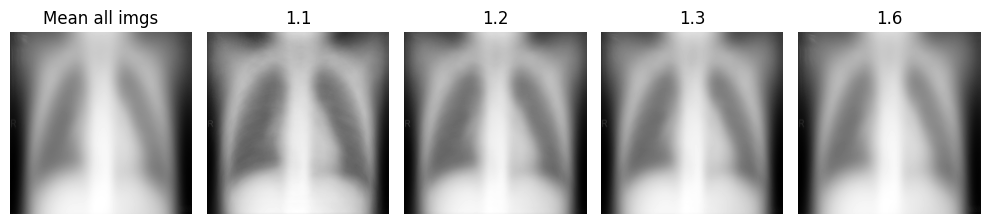

In [10]:
all_imgs = []
sorted_imgs_indexes = {1.1:[], 1.2:[], 1.3:[], 1.6:[]}

def collect_imgs_callback(img):
    global all_imgs
    original_img = img
    img = cv2.resize(img,(800,800))
    all_imgs.append(img)
    for ratio_max, indexes_array in sorted_imgs_indexes.items():
        if sort_image(original_img, max_ratio=ratio_max):
            indexes_array.append(len(all_imgs)-1)
    
browse_imgs(collect_imgs_callback)

mean_images = [np.mean(all_imgs, axis=0)]
titles = ["Mean all imgs"]

for ratio_t, indexes_array in sorted_imgs_indexes.items():
    image_array = [all_imgs[i] for i in indexes_array]
    mean_images.append(np.mean(image_array, axis=0))
    titles.append(ratio_t)

display_imgs(mean_images, titles, plot_size=(1,len(mean_images)), figsize=(10,10))